# <span style="color:green">Evaluation of Satellite Imagery Inputs Used to Create a "Fused" Land Surface Temperature product</span>
Erik Anderson &
Tyler Cruickshank

[Project Repository](https://github.com/eriktuck/ea-lst-capstone)

<img src="assets/anim.gif" width="600" height="400"/>

# <span style="color:green">Project Overview</span>

Maximizing agricultural productivity is critical for maintaining world food supply and controlling food cost. Modern agribusiness employs targeted technology to <span style="color:lightblue">optimize cropland productivity</span> using modern information and communication technologies at fine spatial resolution (within-field scale). 

[Hyrdrosat](https://www.hydrosat.com/) is a value-added satellite data provider whose mission is to provide real-time thermal infrared data to customers in the agribusiness and government sectors. Thermal infrared data can be used to <span style="color:lightblue"> inform adaptive irrigation </span> and <span style="color:lightblue"> predict crop yields </span>. 

Until the upcoming launch of its own 16-satellite constellation, Hydrosat produces estimates of land surface temperature using publicly available thermal infrared data using a combination of MODIS, Sentinel and Landsat imaging platforms. Available data suffers from low spatial and temporal resolutions. Hydrosat utilizes a data mining approach for sharpening thermal satellite imagery (DMS; as described in Gao 2012) and a separate algorithm for interpolating land surface temperature between acquisition windows (STARFM; as described in Gao 2006), to produce a proprietry "Fused" Land Surface Temperature (LST) imagery product resulting in a near daily estimate of LST at sub-30 meter resolution. 

The Fused LST product and its inputs are accessed from a Spatial Temporal Asset Catalog (STAC). STAC is a specification standard with a unified language to describe geospatial data which allows it to be more easily searchable and queryable. Data are served through the [Hydrosat's Fusion Hub](https://hydrosat.github.io/fusion-hub-docs/intro.html). (Credentials for data access must be requested as directed on the Fusion Hub homepage.) 

This project aims to explore the input data and intermediate outputs of the algorithms used to produce the LST product in order to detect errors potentially introduced by data quality isses or the application of the algorithms while also exploring applications within agricultural contexts. 

In [19]:
# Import standard libraries
import base64
from datetime import datetime, timedelta
import json
import os
import yaml

# Import installed libraries
import matplotlib.pyplot as plt
from pystac_client import Client
import seaborn as sns
from shapely.geometry import Point, Polygon

# Import local modules
from library import utils
from library.FH_Hydrosat import FH_Hydrosat

# Read configuration file
with open("config.yml","r") as f:
    config = yaml.safe_load(f)

In [2]:
# Specify crop type
met_tower = 'alfalfa'

# Define paths to data
data_dir = os.path.join('data', 'Ameriflux')
file_name = config[met_tower]['data_params']['file_name']
file_path = os.path.join(data_dir, file_name)

# Read data
bi1_df = utils.read_ameriflux(file_path)
print(f'Data range from {bi1_df.index.min()} to {bi1_df.index.max()}')


Data range from 2016-08-13 00:00:00 to 2022-12-31 23:30:00


In [3]:
# Authenticate and access catalog
with open(os.path.join('secrets', 'creds.json')) as f:
    creds = json.loads(f.read())
    
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [14]:
geom = {'type': 'Point', 'coordinates': config[met_tower]['field_center']}
aoi = Point(geom['coordinates'])

start_date = "2022-01-01T00:00:00Z"
end_date = "2022-12-31T00:00:00Z"

collection = 'prepped_inputs_s2'

if type(aoi) == Point:
    search = catalog.search(
        collections=collection,
        intersects=geom,
        datetime=[start_date, end_date],
        max_items=1000
    )
elif type(aoi) == Polygon:
    search = catalog.search(
        collections=collection,
        aoi=geom,
        datetime=[start_date, end_date],
        max_items=1000
    )


items = search.get_all_items()
print(f'number of source {collection} items: {len(items)}')

number of source prepped_inputs_s2 items: 66


In [18]:
type(pt) == Point

True

# <span style="color:green">Project Location</span>

The project is focused on agricultural areas with active farming in the San Joaquin Valley of California, United States.

# <span style="color:green">Normalized Difference Vegetation Index (NDVI)</span>

The Normalized Difference Vegetation Index (NDVI) is a commonly used remotely sensed index that provides data on the "greenness" or health of crop vegetation. However, the NDVI index is a lagging indicator of crop stress because water or heat stress occurs prior to the degradation of vegetation greenness.

In [ ]:
ndvi_series = utils.ndvi_from_collection(
    items, geom_point=pt, tolerance=40, red_band=2, nir_band=6, name='s2')

using 6 processes to sample 66 assets
using 6 processes to sample 66 assets


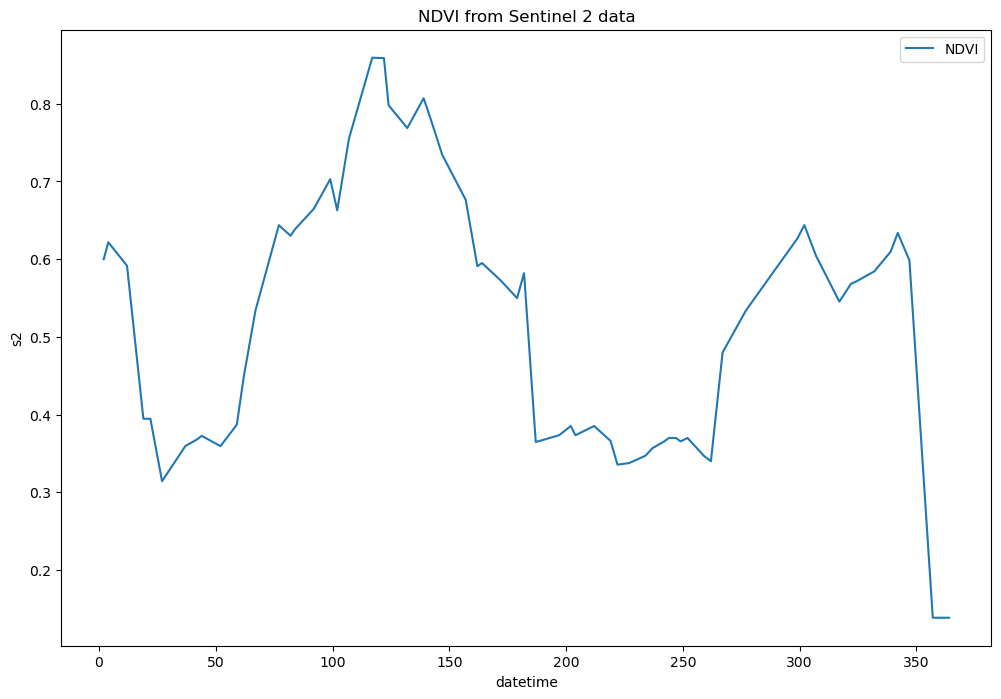

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=ndvi_series.index.dayofyear,
             y=ndvi_series, ax=ax,
             label='NDVI').set(title='NDVI from Sentinel 2 data');

## <span style="color:green">Collaborators </span>

- [Erik Anderson](https://github.com/eriktuck)
- [Tyler Cruickshank](https://github.com/tcruicks)
- [Joe McGlinchy](https://github.com/joemcglinchy)
We thank Joe McGlinchy of Hydrosat for providing project guidance and data access.

## <span style="color:green">References</span>

Gao, F. Masek, J. Schwaller, M. Hall, F. 2006. On the Blending of Landsat and MODIS Surface Reflectance: Predicting Landsat Surface Reflectance. IEE Transaction on Geoscience and Remote Sensing Vol 44, No 8.

Gao, F. Kustas, W. Anderson, M. 2012. A Data Mining Approach for Sharpening Thermal Satellite Imagery Over Land. Remote Sensing. doi: 10.3390/rs4113287.

Karnieli, A., Agam, N., Pinker, R., Anderseon, M., Imhoff, M., Gutman, G., Panov, N., Goldberg, A., Use of NDVI and Land Surface Temperature for Drought Assessment: Merits and Limitations.  Journal of Climate. Vol 23. 2010

Y. Erdem , T. Erdem , A.H. Orta & H. Okursoy. Canopy-air temperature differential for potato under different irrigation regimes. Acta Agriculturae Scandinavica Section B-Soil and Plant Science, 2006; 56: 206216